# ELEN0016: Computer Vision Project
## Cell Detection and Counting inside droplets

In this project, we will try to detect and count cells inside droplets. The images are contained in a `.tif` sequence and we will use the `opencv-python` library to process them.

## Imports

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import json

## Creation of different folders and specification of the paths

In [2]:
DATA_PATH = 'renaud_data/'
SEQUENCES_PATH = DATA_PATH + 'sequences/'
DROPLETS_PATH = DATA_PATH + 'droplets/'
GENERATED_PATH = DATA_PATH + 'generated/'
INTEREST_FILE = 'renaud.tif'

if not os.path.exists(DROPLETS_PATH):
    os.makedirs(DROPLETS_PATH)
else:
    for file in os.listdir(DROPLETS_PATH):
        os.remove(os.path.join(DROPLETS_PATH, file))
    os.rmdir(DROPLETS_PATH)
    os.makedirs(DROPLETS_PATH)

if not os.path.exists(GENERATED_PATH):
    os.makedirs(GENERATED_PATH)
else:
    for file in os.listdir(GENERATED_PATH):
        os.remove(os.path.join(GENERATED_PATH, file))
    os.rmdir(GENERATED_PATH)
    os.makedirs(GENERATED_PATH)

## Image loading

In [3]:
def load_sequence(file):
    return cv2.imreadmulti(file, flags=cv2.IMREAD_GRAYSCALE)[1]

def load_image(file):
    return cv2.imread(file, flags=cv2.IMREAD_GRAYSCALE)

Loading sequence from file: renaud_data/sequences/renaud.tif


Loaded 50 images
First image: 


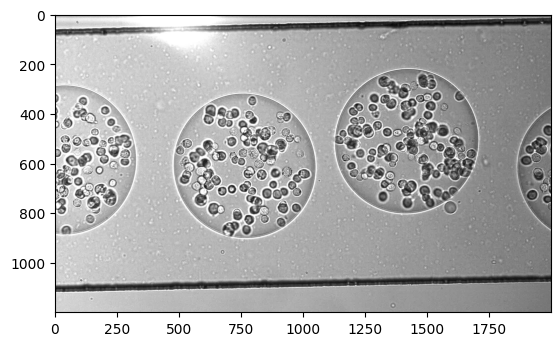

In [4]:
file = SEQUENCES_PATH + INTEREST_FILE
print('Loading sequence from file: {}'.format(file))

images = np.array(load_sequence(file))
nb_images = images.shape[0]

print('Loaded {} images'.format(nb_images))
print('First image: ')
plt.imshow(images[0], cmap='gray')
plt.show()

## Background subtraction and mask creation

In [5]:
def background_substraction(images):
    bg = np.median(images, axis=0)
    mask = np.abs(images - bg) > 35
    mask = mask / np.max(mask)
    return mask.astype(np.uint8) * 255

def get_masks(images):
    masks = background_substraction(images)
    return masks

masks = get_masks(images)

First mask: 


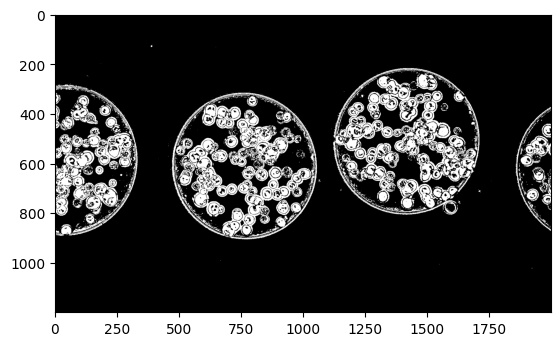

In [6]:
print('First mask: ')
plt.imshow(masks[0], cmap='gray')
plt.show()

## Bounding box creation

In [7]:
def get_contours(mask):
    def get_boundaries(mask):
        boundaries = np.zeros(mask.shape)
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            if cv2.contourArea(contour) > 350:
                cv2.drawContours(boundaries, [contour], 0, 255, 5)

        return np.array(boundaries, dtype=np.uint8)
    
    def get_circles(mask):
        return cv2.HoughCircles(mask, cv2.HOUGH_GRADIENT, dp=1, minDist=500, param1=50, param2=20, minRadius=270, maxRadius=350)
    
    def get_bb(mask):
        circles = get_circles(mask)
        bb = []
        if circles is not None:
            circles = np.uint16(np.around(circles))
            for circle in circles[0,:]:
                x, y, r = circle
                x = int(x)
                y = int(y)
                r = int(r)
                if x-r < 0 or y-r < 0 or x+r > mask.shape[1] or y+r > mask.shape[0]:
                    continue
                bb.append((x-r, y-r, 2*r, 2*r))
        return bb
    
    mask = get_boundaries(mask)
    bb = get_bb(mask)
    return mask, bb

def draw_bbs(masks):
    ims_bb = []

    print('Drawing bounding boxes...')
    for mask in tqdm(masks):
        im_bb = mask.copy()
        bb = get_contours(mask)[1]
        for b in bb:
            cv2.rectangle(im_bb, (b[0], b[1]), (b[0]+b[2], b[1]+b[3]), 255, 5)
        ims_bb.append(im_bb)

    return ims_bb

def get_bbs(masks):
    bbs = []
    print('Getting bounding boxes...')
    for mask in tqdm(masks):
        bb = get_contours(mask)[1]
        bbs.append(bb)
    return bbs

masks_with_bbs = draw_bbs(masks)
bounding_boxes = get_bbs(masks)

Drawing bounding boxes...


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:06<00:00,  7.25it/s]


Getting bounding boxes...


100%|██████████| 50/50 [00:06<00:00,  7.32it/s]


First bounding boxes: 
[(1129, 213, 582, 582), (471, 325, 586, 586)]
First contour: 


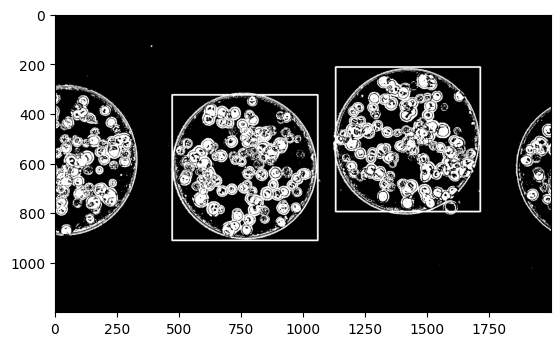

In [8]:
print('First bounding boxes: ')
print(bounding_boxes[0])

print('First contour: ')
plt.imshow(masks_with_bbs[0], cmap='gray')
plt.show()

## Counting the cells inside the droplets

In [9]:
for frame in tqdm(range(len(bounding_boxes))):
    for bb_id, _ in enumerate(bounding_boxes[frame]):
        x, y, w, h = bounding_boxes[frame][bb_id]
        droplet = masks[frame][y:y+h, x:x+w]
        cv2.imwrite(DROPLETS_PATH + 'droplet_{}_{}.tif'.format(str(frame+1).zfill(2), bb_id), droplet)
        
        with open(DROPLETS_PATH + 'droplet_{}_{}.json'.format(str(frame+1).zfill(2), bb_id), 'w') as f:
            json.dump({'x': x, 'y': y, 'w': w, 'h': h}, f)

print('Number of dectected droplets: {}'.format(len(os.listdir(DROPLETS_PATH))/2))

100%|██████████| 50/50 [00:00<00:00, 91.96it/s] 

Number of dectected droplets: 107.0


In [10]:
def count_cells(file):
    return [[1,1]]

In [11]:
name = INTEREST_FILE.split('.')[0]
filenames_droplets = os.listdir(DROPLETS_PATH)
files_tif = [f for f in filenames_droplets if f.endswith('.tif')]

for frame in tqdm(range(1, nb_images+1)):
    files = [f for f in files_tif if f.startswith('droplet_{}'.format(str(frame).zfill(2)))]

    for file in files:
        cells = count_cells(file)
        file_json = file.replace('.tif', '.json')

        with open(DROPLETS_PATH + file_json, 'r') as f:
            box = json.load(f)
            box = [box['x'], box['y'], box['w'], box['h']]

        with open(GENERATED_PATH + file_json, 'w') as f:
            json.dump({name + '_frame_' + str(frame): {'box': box, 'cells': cells}}, f)

100%|██████████| 50/50 [00:00<00:00, 856.03it/s]


## Combine the json files into a final one

In [13]:
inc = 0

files_generated = os.listdir(GENERATED_PATH)
files_json = [f for f in files_generated if f.endswith('.json')]
files_json.sort()

complete_data = []
for file in tqdm(files_json):
    with open(GENERATED_PATH + file, 'r') as f:
        data = json.load(f)
        inc += 1
        complete_data.append((data, inc))

merged_data = {}
for data, inc in complete_data:
    for key, value in data.items():
        if key not in merged_data:
            merged_data[key] = {'boxes': [], 'cells': []}
        
        merged_data[key]['boxes'].append(value['box'] + [inc])
        merged_data[key]['cells'].extend([cell + [inc] for cell in value['cells']])

with open(SEQUENCES_PATH + 'complete_data.json', 'w') as f:
    json.dump(merged_data, f)

100%|██████████| 107/107 [00:00<00:00, 6945.82it/s]


## Annotating the original images with the bounding boxes and cells

In [24]:
file = SEQUENCES_PATH + INTEREST_FILE

with open(SEQUENCES_PATH + 'complete_data.json', 'r') as f:
    annotations = json.load(f)

images = np.array(load_sequence(file))
images = np.stack((images,)*3, axis=-1)

colors = np.random.randint(0, 255, (200, 3))

computed = []

for i in tqdm(range(images.shape[0])):
    image = images[i]
    frame_id = INTEREST_FILE.split('.')[0] + '_frame_' + str(i+1)

    for cell in annotations[frame_id]['cells']:
        color = colors[int(cell[2])]
        color_list = [int(color[0]), int(color[1]), int(color[2])]
        cv2.circle(image, (int(cell[0]), int(cell[1])), 5, color_list, -1)

    for box in annotations[frame_id]['boxes']:
        color = colors[int(box[4])]
        color_list = [int(color[0]), int(color[1]), int(color[2])]
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[0]+box[2]), int(box[1]+box[3])), color_list, 2)

    computed.append(image)

cv2.imwritemulti(SEQUENCES_PATH + 'computed.tif', np.array(computed));       

100%|██████████| 50/50 [00:00<00:00, 2253.96it/s]


## Checking the annotations

### Checking the types of the annotations (should print nothing)

In [25]:
for frame in annotations:
    for cell in annotations[frame]['cells']:
        if (type(cell[0]) != int and type(cell[0]) != float) or (type(cell[1]) != int and type(cell[1]) != float) or (type(cell[2]) != int and type(cell[2]) != float):
            print("cell ", cell)
    for box in annotations[frame]['boxes']:
        if (type(box[0]) != int and type(box[0]) != float) or (type(box[1]) != int and type(box[1]) != float) or (type(box[2]) != int and type(box[2]) != float) or (type(box[3]) != int and type(box[3]) != float) or (type(box[4]) != int and type(box[4]) != float):
            print("box ", box)

### Checking the key names of the annotations

In [26]:
for frame in annotations:
    print(frame)

renaud_frame_1
renaud_frame_2
renaud_frame_3
renaud_frame_4
renaud_frame_5
renaud_frame_6
renaud_frame_7
renaud_frame_8
renaud_frame_9
renaud_frame_10
renaud_frame_11
renaud_frame_12
renaud_frame_13
renaud_frame_14
renaud_frame_15
renaud_frame_16
renaud_frame_17
renaud_frame_18
renaud_frame_19
renaud_frame_20
renaud_frame_21
renaud_frame_22
renaud_frame_23
renaud_frame_24
renaud_frame_25
renaud_frame_26
renaud_frame_27
renaud_frame_28
renaud_frame_29
renaud_frame_30
renaud_frame_31
renaud_frame_32
renaud_frame_33
renaud_frame_34
renaud_frame_35
renaud_frame_36
renaud_frame_37
renaud_frame_38
renaud_frame_39
renaud_frame_40
renaud_frame_41
renaud_frame_42
renaud_frame_43
renaud_frame_44
renaud_frame_45
renaud_frame_46
renaud_frame_47
renaud_frame_48
renaud_frame_49
renaud_frame_50


### Checking the number of keys per annotation (should print nothing)

In [27]:
for frame in annotations:
    if len(annotations[frame].keys()) != 2:
        print(frame)

### Checking the numbrt of different ID values (should print somewhere around 30)

In [28]:
ids = []

for frame in annotations:
    for cell in annotations[frame]['cells']:
        ids.append(cell[2])
    for box in annotations[frame]['boxes']:
        ids.append(box[4])

print(len(set(ids)))

107


### Checking the number of keys inside the dictionary (should print 50)

In [29]:
print(len(annotations.keys()))

50


### Checking the length of each box and cell sublist inside the dictionary (should print nothing)

In [30]:
for frame in annotations:
    for cell in annotations[frame]['cells']:
        if len(cell) != 3:
            print(frame, cell)
    for box in annotations[frame]['boxes']:
        if len(box) != 5:
            print(frame, box)